In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 300
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow_addons as tfa

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Importing Data

In [2]:
Data_deltaeta_spin0_coll = pd.read_csv( '../input/lhc-events-pp-a-ee-pp-z-ee/deltaeta_spin0_coll.txt', names=['deltaeta_spin0_coll'])
Data_deltaeta_spin2ff_coll = pd.read_csv( '../input/lhc-events-pp-a-ee-pp-z-ee/deltaeta_spin2ff_coll.txt', names=['deltaeta_spin2ff_coll'] )

# Delta Eta Plots

In [3]:
columns = ['deltaeta_spin0_coll','deltaeta_spin2ff_coll']
fig = ff.create_distplot([ Data_deltaeta_spin0_coll['deltaeta_spin0_coll'], Data_deltaeta_spin2ff_coll['deltaeta_spin2ff_coll'] ], columns, bin_size=0.1, show_hist=True, show_rug=False)
fig.layout.update({'title': 'Delta Eta' })
fig.show()

In [4]:
Data_deltaeta_spin2ff_coll['label'] = 1
Data_deltaeta_spin0_coll['label'] = 0
Data_deltaeta_spin2ff_coll = Data_deltaeta_spin2ff_coll.rename(columns={'deltaeta_spin2ff_coll':'deltaeta'})
Data_deltaeta_spin0_coll = Data_deltaeta_spin0_coll.rename(columns={'deltaeta_spin0_coll':'deltaeta'})

In [5]:
def get_hist_value( value, bin_edges, hist ):
    for edges in bin_edges:
        if value <= edges:
            index = np.where( bin_edges == edges )
            hist_value = hist[index[0][0]-1]
            break
    return hist_value

def Get_Histogram_Values_Dataframe( Data, column_name ):
    hist, bin_edges = np.histogram(Data['deltaeta'], density=True, bins=50)
    Data['hist_value'] = np.nan
    for index in range(0,Data.shape[0]):
        Data.at[index,'hist_value'] = get_hist_value( Data.at[index,column_name], bin_edges, hist)
    return Data

In [6]:
Data_deltaeta_spin0_coll = Get_Histogram_Values_Dataframe( Data_deltaeta_spin0_coll , column_name = 'deltaeta'  )
Data_deltaeta_spin2ff_coll = Get_Histogram_Values_Dataframe( Data_deltaeta_spin2ff_coll , column_name = 'deltaeta'  )

In [7]:
Data = pd.concat([Data_deltaeta_spin0_coll, Data_deltaeta_spin2ff_coll], axis=0)
Data

,deltaeta,label,hist_value
0,2.700,0,0.045300
1,-1.230,0,0.183529
2,-0.315,0,0.271342
3,0.401,0,0.269137
4,-0.123,0,0.275793
...,...,...,...
133615,-1.460,1,0.290803
133616,-1.220,1,0.293179
133617,2.500,1,0.090797
133618,-2.390,1,0.109289


In [8]:
Data['hist_value'].unique()

array([4.52998724e-02, 1.83528960e-01, 2.71341660e-01, 2.69136983e-01,
       2.75792612e-01, 1.04534967e-01, 2.33945347e-01, 1.88187900e-01,
       2.04036615e-01, 2.08196383e-01, 2.50542821e-01, 2.75917405e-01,
       9.91272690e-02, 1.54701768e-01, 2.57489633e-02, 1.44052762e-01,
       2.58903954e-01, 2.79536403e-02, 1.69635335e-01, 5.67392342e-02,
       1.57613606e-01, 8.09906810e-02, 2.41682515e-01, 2.82614631e-01,
       1.26997714e-01, 1.90101393e-02, 1.16556697e-01, 7.01336868e-02,
       8.67727584e-02, 2.27705695e-01, 1.95093114e-02, 4.14728860e-02,
       3.23629943e-02, 1.08569942e-02, 7.52917990e-02, 1.46423830e-02,
       3.63563714e-02, 7.61237526e-03, 5.34114198e-02, 9.60906385e-03,
       7.77876597e-03, 1.36024410e-02, 2.78704449e-03, 2.45426306e-03,
       3.61899807e-03, 5.44929595e-03, 4.99172148e-04, 3.74379111e-04,
       9.56746617e-04, 1.45591876e-03, 2.47562978e-01, 2.73657668e-01,
       1.54984244e-01, 2.66767719e-01, 2.92783215e-01, 5.70994584e-02,
      

# Pie Chart of Labels

label
1        133620
0        124947
dtype: int64
-----------------------------


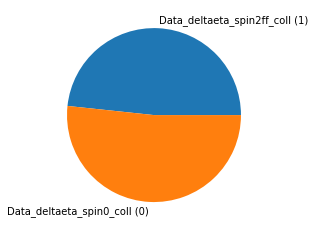

In [9]:
Data_deltaeta_spin2ff_coll_counts = Data[['label']].value_counts()[0]
Data_deltaeta_spin0_coll_counts = Data[['label']].value_counts()[1]
plt.pie( [Data_deltaeta_spin2ff_coll_counts, Data_deltaeta_spin0_coll_counts ], labels=[ 'Data_deltaeta_spin2ff_coll (1)' ,'Data_deltaeta_spin0_coll (0)'] )
print( Data[['label']].value_counts() )
print('-----------------------------')

In [10]:
X = Data[['deltaeta','hist_value']]
y = Data[['label']]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=10, stratify=y)

# Applying ANN Model

In [11]:
# Plotting Loss vs epochs graph, Accuaracy vs epochs graph
def Plot_Loss_Accuracy( history, epochs ):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']

    epochs = np.linspace(1,epochs,epochs)
    epochs

    fig = go.Figure(data=go.Scatter( x=epochs, y=loss, name='loss' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_loss, name='val_loss' ) )
    fig.update_layout( title="Loss", xaxis_title='epochs' )
    fig.show()

    fig = go.Figure(data=go.Scatter( x=epochs, y=auc, name='auc' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_auc, name='val_auc' ) )
    fig.update_layout( title="ROC Score", xaxis_title='epochs' )
    fig.show()
    

auc_roc_metric_ROC = tf.keras.metrics.AUC(curve='ROC')
# auc_roc_metric_PR = tf.keras.metrics.AUC(curve='PR')
# f1_score = tfa.metrics.F1Score(num_classes=1,average='weighted')


def Plot_ROC_AUC_Curve( model ): ## Using Entire Data for predicting (i.e. using X )
    
    y_predict = model.predict(X)
    
    # For Signal
    fpr, tpr, thresh = roc_curve(y, y_predict)
    plt.style.use('seaborn')
    plt.plot(fpr, tpr, linestyle='--',color='green', label='Model_Name')

    #  ROC_AUC_Score
    score = roc_auc_score(y, y_predict, average='weighted')
    print("ROC AUC Score | weighted  = ",score)
    print("\n")

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y))]
    p_fpr, p_tpr, _ = roc_curve(y, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.title( " ROC Curve " )

2022-09-28 13:23:19.412981: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# One Layer

In [12]:
# Neural network
model = Sequential()

model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy', auc_roc_metric_ROC])

history = model.fit(X_train, y_train , validation_data=(X_test,y_test), epochs=10, batch_size=32)

2022-09-28 13:23:19.815450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
6061/6061 [==============================] - 13s 2ms/step - loss: 0.5960 - accuracy: 0.6976 - auc: 0.8020 - val_loss: 0.5174 - val_accuracy: 0.8176 - val_auc: 0.8572
Epoch 2/10
6061/6061 [==============================] - 12s 2ms/step - loss: 0.4669 - accuracy: 0.8281 - auc: 0.8652 - val_loss: 0.4205 - val_accuracy: 0.8455 - val_auc: 0.8841
Epoch 3/10
6061/6061 [==============================] - 11s 2ms/step - loss: 0.3795 - accuracy: 0.8543 - auc: 0.9112 - val_loss: 0.3449 - val_accuracy: 0.8493 - val_auc: 0.9457
Epoch 4/10
6061/6061 [==============================] - 11s 2ms/step - loss: 0.3078 - accuracy: 0.8644 - auc: 0.9699 - val_loss: 0.2780 - val_accuracy: 0.8759 - val_auc: 0.9818
Epoch 5/10
6061/6061 [==============================] - 11s 2ms/step - loss: 0.2557 - accuracy: 0.9040 - auc: 0.9828 - val_loss: 0.2393 - val_accuracy: 0.9122 - val_auc: 0.9852
Epoch 6/10
6061/6061 [==============================] - 11s 2ms/step - loss: 0.2272 - accuracy: 0.9114 - auc: 0.984

ROC AUC Score | weighted  =  0.9884274755277258




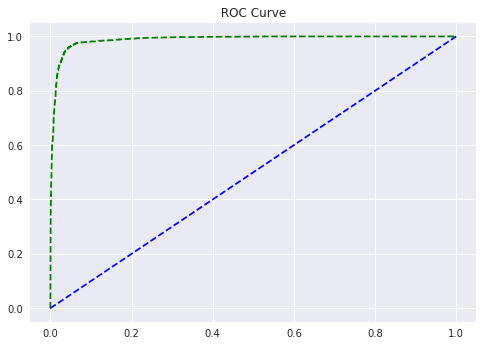

In [13]:
Plot_Loss_Accuracy( history, epochs=20 )
Plot_ROC_AUC_Curve( model )

In [19]:
Data_deltaeta_spin2gg_coll = pd.read_csv( '../input/lhc-events-pp-a-ee-pp-z-ee/deltaeta_spin2gg_coll.txt', names=['deltaeta_spin2gg_coll'])
Data_deltaeta_spin2ff_noncoll = pd.read_csv( '../input/lhc-events-pp-a-ee-pp-z-ee/deltaeta_spin2ff_noncoll.txt', names=['deltaeta_spin2ff_noncoll'] )

Data_deltaeta_spin2gg_coll['label'] = 1
Data_deltaeta_spin2ff_noncoll['label'] = 0
Data_deltaeta_spin2gg_coll = Data_deltaeta_spin2gg_coll.rename(columns={'deltaeta_spin2gg_coll':'deltaeta'})
Data_deltaeta_spin2ff_noncoll = Data_deltaeta_spin2ff_noncoll.rename(columns={'deltaeta_spin2ff_noncoll':'deltaeta'})

Data_deltaeta_spin2gg_coll = Get_Histogram_Values_Dataframe( Data_deltaeta_spin2gg_coll , column_name = 'deltaeta'  )
Data_deltaeta_spin2ff_noncoll = Get_Histogram_Values_Dataframe( Data_deltaeta_spin2ff_noncoll , column_name = 'deltaeta'  )

Data_Test = pd.concat([Data_deltaeta_spin2gg_coll, Data_deltaeta_spin2ff_noncoll], axis=0)
Data_Test

,deltaeta,label,hist_value
0,-0.0239,1,0.475573
1,1.5400,1,0.080181
2,0.1760,1,0.471065
3,1.6300,1,0.080181
4,0.0969,1,0.475573
...,...,...,...
138823,0.1650,0,0.323912
138824,0.0347,0,0.323912
138825,0.1710,0,0.323912
138826,-1.2400,0,0.212148


Applying Model Test Data

ROC AUC Score | weighted  =  0.8878477399602376




Text(0.5, 1.0, ' ROC Curve ')

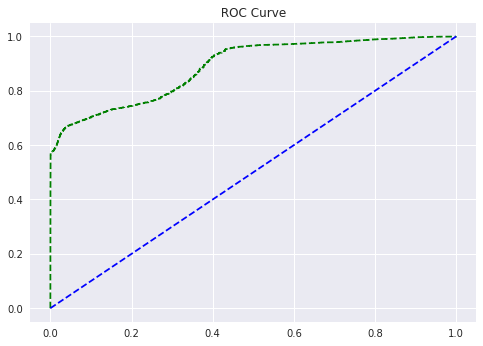

In [22]:
# Predicting Target 
Predicted_Labels = model.predict(Data_Test[['deltaeta','hist_value']])

# For Signal
fpr, tpr, thresh = roc_curve(Data_Test[['label']], Predicted_Labels)
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='green', label='Model_Name')

#  ROC_AUC_Score
score = roc_auc_score(Data_Test[['label']], Predicted_Labels, average='weighted')
print("ROC AUC Score | weighted  = ",score)
print("\n")

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Data_Test[['label']]))]
p_fpr, p_tpr, _ = roc_curve(Data_Test[['label']], random_probs, pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title( " ROC Curve " )

***

# Two Layers

In [ ]:
# Neural network
model = Sequential()

model.add(Dense(400, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(100,  activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy', auc_roc_metric_ROC])

history = model.fit(X_train, y_train , validation_data=(X_test,y_test), epochs=10, batch_size=32)

Plot_Loss_Accuracy( history, epochs=10 )
Plot_ROC_AUC_Curve( model )

# Three Layers

In [ ]:
# # Neural network
# model = Sequential()

# model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(100,  activation='relu'))
# model.add(Dense(100,  activation='relu'))

# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy', auc_roc_metric_ROC])

# history = model.fit(X_train, y_train , validation_data=(X_test,y_test), epochs=10, batch_size=32)

# Plot_Loss_Accuracy( history, epochs=10 )
# Plot_ROC_AUC_Curve( model )

# Applying ML Algorithms

In [ ]:
def Evaluation(model,X_train,X_test,y_train,y_test,hypertuning=False):

  plt.figure(  figsize=(12,6) )
  print( "-----------------------------------------------------------------------------------------------------------")
  print( model )
  print( " For Train Set :  ")
  y_pred = model.predict(X_train)
  y_pred_proba = model.predict_proba(X_train)

  if hypertuning==True:
    print("Param for GS", model.best_params_)
    print("CV score for GS", model.best_score_)

  accuracy_train = accuracy_score( y_train, y_pred )
  precision_train = precision_score( y_train, y_pred )
  recall_train = recall_score(y_train, y_pred)
  F1_score_train = f1_score(y_train, y_pred)
  print("F1_Score = ", F1_score_train )
  roc_auc_train = roc_auc_score(y_train, y_pred_proba[:,1])
  print( classification_report( y_train, y_pred ) )

  print( " For Test Set :  ")
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)

  accuracy_test = accuracy_score( y_test, y_pred )
  precision_test = precision_score( y_test, y_pred )
  recall_test = recall_score(y_test, y_pred)
  F1_score_test = f1_score(y_test, y_pred)
  print("F1_Score = ", F1_score_test )
  roc_auc_test = roc_auc_score(y_test, y_pred_proba[:,1])
  print( classification_report( y_test, y_pred ) )

  print('------------------------------------------------------------------------------------------------------------')
  print("\n")

#   fpr, tpr, thresh = roc_curve( y_test, y_pred )
#   plt.plot( fpr, tpr, label=model + str( auc_score ) ) 
  return  accuracy_train, precision_train, recall_train, F1_score_train, roc_auc_train, accuracy_test, precision_test, recall_test, F1_score_test, roc_auc_test

In [ ]:
def apply_models_with_default_paramters(X_train,X_test,y_train,y_test):
  models_default = [ RandomForestClassifier(), DecisionTreeClassifier(), XGBClassifier(),
                     ExtraTreeClassifier(), KNeighborsClassifier(),# SVC(probability=True),
                     LogisticRegression(), AdaBoostClassifier(), GaussianNB()
                     ]

  
  F1_Score_train = []
  Accuracy_train = []
  Recall_train = []
  Precision_train = []
  ROC_AUC_Score_train = []


  F1_Score_test = []
  Accuracy_test = []
  Recall_test = []
  Precision_test = []
  ROC_AUC_Score_test = []

  Model_Name = []

  for model in models_default:
    print(model)
    Model_Name.append( model )
    model.fit(X_train, y_train)

    accuracy_train, precision_train, recall_train, F1_score_train, roc_auc_train, accuracy_test, precision_test, recall_test, F1_score_test, roc_auc_test = Evaluation(model,X_train,X_test,y_train,y_test,False)
    
    F1_Score_train.append( F1_score_train )
    Accuracy_train.append( accuracy_train )
    Recall_train.append( recall_train )
    Precision_train.append( precision_train )
    ROC_AUC_Score_train.append( roc_auc_train )

    F1_Score_test.append( F1_score_test )
    Accuracy_test.append( accuracy_test )
    Recall_test.append( recall_test )
    Precision_test.append( precision_test )
    ROC_AUC_Score_test.append( roc_auc_test )
    
  results = pd.DataFrame()
  results['Model_Name'] = Model_Name
    
  train_test_f1_score_difference = np.subtract(F1_Score_train,F1_Score_test)  # To Check Overfitting/Underfitting

  results['F1_Score on Test Set'] = F1_Score_test
  results['Accuracy on Test Set'] = Accuracy_test
  results['Recall on Test Set'] = Recall_test
  results['Precision on Test Set'] = Precision_test
  results['ROC_AUC_Score on Test Set'] = ROC_AUC_Score_test

  results['F1_Score on Train Set'] = F1_Score_train
  results['Accuracy on Train Set'] = Accuracy_train
  results['Recall on Train Set'] = Recall_train
  results['Precision on Train Set'] = Precision_train
  results['ROC_AUC_Score on Train Set'] = ROC_AUC_Score_train

  results['Difference of F1_Score on train and test'] = train_test_f1_score_difference

  results = results.sort_values(by=['F1_Score on Test Set','Difference of F1_Score on train and test'],ascending = [False, True]) 

  return results

In [ ]:
Results = apply_models_with_default_paramters(X_train,X_test,y_train,y_test)
Results

In [ ]:
model = XGBClassifier()
model.fit(X_train,y_train)

In [ ]:
# Test = pd.DataFrame()
# Test['deltaeta'] = [2.700, -2.390, -0.123, 0.401 ]
# Test

# y_pred = model.predict(Test)
# y_pred